# Rule Variations

This notebook demonstrates the implementation of Blackjack with Basic Strategy and Complete Point-Count System under different rule variations. We compare the win rates for the following rule variations:
1. Dealer Hits Soft 17 (H17)
2. Early Surrender


# Basic Strategy with Rule Variation

In [1]:
import numpy as np
import random

class BlackjackEnv:
    def __init__(self, dealer_hits_soft_17=True, early_surrender=False):
        self.deck = self.init_deck()
        self.player_hand = []
        self.dealer_hand = []
        self.split_hand = []
        self.doubled = False
        self.rewards = []
        self.hand_lengths = []
        self.dealer_hits_soft_17 = dealer_hits_soft_17
        self.early_surrender = early_surrender
        self.reset_game()

    def init_deck(self):
        suits = ['hearts', 'diamonds', 'clubs', 'spades']
        ranks = list(range(2, 11)) + ['jack', 'queen', 'king', 'ace']
        deck = [str(rank) + '_' + suit for rank in ranks for suit in suits]
        random.shuffle(deck)
        return deck

    def draw_card(self):
        return self.deck.pop(random.randint(0, len(self.deck) - 1))

    def reset_game(self):
        self.deck = self.init_deck()
        self.player_hand = [self.draw_card(), self.draw_card()]
        self.dealer_hand = [self.draw_card(), self.draw_card()]

    def get_card_value(self, card):
        rank = card.split('_')[0]
        if rank in ['jack', 'queen', 'king']:
            return 10
        elif rank == 'ace':
            return 11
        else:
            return int(rank)

    def hand_value(self, hand):
        value = sum(self.get_card_value(card) for card in hand)
        if value > 21 and any(card.startswith('ace') for card in hand):
            value -= 10
        return value

    def is_soft_hand(self, hand):
        return any(card.startswith('ace') for card in hand) and self.hand_value(hand) <= 21

    def is_busted(self, hand):
        return self.hand_value(hand) > 21

    def dealer_play(self):
        while self.hand_value(self.dealer_hand) < 17 or (self.dealer_hits_soft_17 and self.hand_value(self.dealer_hand) == 17 and self.is_soft_hand(self.dealer_hand)):
            self.dealer_hand.append(self.draw_card())

    def is_pair(self, hand):
        return len(hand) == 2 and hand[0].split('_')[0] == hand[1].split('_')[0]

    def step(self, action):
        if action == 'hit':
            self.player_hand.append(self.draw_card())
            if self.is_busted(self.player_hand):
                self.rewards.append(-1)
                self.hand_lengths.append(len(self.player_hand))
                return 'terminal', -2 if self.doubled else -1, True
        elif action == 'stand':
            self.dealer_play()
            player_value = self.hand_value(self.player_hand)
            dealer_value = self.hand_value(self.dealer_hand)
            if self.is_busted(self.dealer_hand) or player_value > dealer_value:
                self.rewards.append(1)
                self.hand_lengths.append(len(self.player_hand))
                return 'terminal', 1, True
            elif dealer_value > player_value:
                self.rewards.append(-1)
                self.hand_lengths.append(len(self.player_hand))
                return 'terminal', -1, True
            else:
                self.rewards.append(0)
                self.hand_lengths.append(len(self.player_hand))
                return 'terminal', 0, True

        elif action == 'split' and self.is_pair(self.player_hand):
            self.split_hand = [self.player_hand.pop()]
            self.player_hand.append(self.draw_card())
            self.split_hand.append(self.draw_card())
            return self.get_state(), 0, False

        elif action == 'double':
            self.doubled = True
            self.player_hand.append(self.draw_card())
            if self.is_busted(self.player_hand):
                return 'terminal', -2, True
            return self.get_state(), 0, False

        return self.get_state(), 0, False

    def get_state(self):
        return (
            self.hand_value(self.player_hand),
            self.get_card_value(self.dealer_hand[0]),
            self.is_soft_hand(self.player_hand),
            len(self.split_hand) > 0,
            self.doubled
        )


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

class QLearningAgent:
    def __init__(self, env, episodes, start_epsilon, decay_epsilon, min_epsilon, learning_rate=0.1, discount=0.99):
        self.env = env
        self.alpha = learning_rate
        self.gamma = discount
        self.epsilon = start_epsilon
        self.total_episodes = episodes
        self.epsilon_decay = decay_epsilon
        self.min_epsilon = min_epsilon
        self.Q = defaultdict(float)
        self.errors = []
        self.episode_rewards = []

    def get_q_value(self, state, action):
        return self.Q.get((state, action), 0)

    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(['hit', 'stand'])
        else:
            return max(['hit', 'stand'], key=lambda action: self.get_q_value(state, action))

    def update_q_value(self, state, action, next_state, reward):
        current_q = self.get_q_value(state, action)
        next_q = max(self.get_q_value(next_state, a) for a in ['hit', 'stand'])
        td_error = reward + self.gamma * next_q - current_q
        self.Q[(state, action)] = current_q + self.alpha * td_error
        self.errors.append(td_error)

    def decay_epsilon(self):
        self.epsilon = max(self.min_epsilon, self.epsilon - self.epsilon_decay)

    def train(self):
        for episode in range(self.total_episodes):
            self.env.reset_game()
            state = self.env.get_state()
            done = False
            total_reward = 0
            while not done:
                action = self.choose_action(state)
                next_state, reward, done = self.env.step(action)
                self.update_q_value(state, action, next_state, reward)
                state = next_state
                total_reward += reward
            self.episode_rewards.append(total_reward)
            self.decay_epsilon()

    def evaluate(self, num_games=1000):
        win, loss, tie = 0, 0, 0
        for _ in range(num_games):
            self.env.reset_game()
            state = self.env.get_state()
            done = False
            while not done:
                action = max(['hit', 'stand'], key=lambda action: self.get_q_value(state, action))
                state, reward, done = self.env.step(action)
            if reward > 0:
                win += 1
            elif reward < 0:
                loss += 1
            else:
                tie += 1
        return win, loss, tie

def train_agent_with_variations(env_params, episodes=100000):
    environment = BlackjackEnv(**env_params)
    agent = QLearningAgent(environment, episodes, start_epsilon=1.0, decay_epsilon=1.0 / (episodes / 2), min_epsilon=0.1)
    agent.train()
    return agent

env_params_h17 = {'dealer_hits_soft_17': True, 'early_surrender': False}
agent_h17 = train_agent_with_variations(env_params_h17)

env_params_surrender = {'dealer_hits_soft_17': False, 'early_surrender': True}
agent_surrender = train_agent_with_variations(env_params_surrender)


In [ ]:
# Evaluate the agents' performance
wins_h17, losses_h17, ties_h17 = agent_h17.evaluate(num_games=10000)
wins_surrender, losses_surrender, ties_surrender = agent_surrender.evaluate(num_games=10000)

# Calculate win, loss, and tie rates
total_games_h17 = wins_h17 + losses_h17 + ties_h17
win_rate_h17 = (wins_h17 / total_games_h17) * 100
loss_rate_h17 = (losses_h17 / total_games_h17) * 100
tie_rate_h17 = (ties_h17 / total_games_h17) * 100

total_games_surrender = wins_surrender + losses_surrender + ties_surrender
win_rate_surrender = (wins_surrender / total_games_surrender) * 100
loss_rate_surrender = (losses_surrender / total_games_surrender) * 100
tie_rate_surrender = (ties_surrender / total_games_surrender) * 100

print(f"H17 Evaluation: {wins_h17} wins, {losses_h17} losses, {ties_h17} ties")
print(f"H17 Win rate: {win_rate_h17:.2f}%, Loss rate: {loss_rate_h17:.2f}%, Tie rate: {tie_rate_h17:.2f}%")

print("-" * 50)

print(f"Surrender Evaluation: {wins_surrender} wins, {losses_surrender} losses, {ties_surrender} ties")
print(f"Surrender Win rate: {win_rate_surrender:.2f}%, Loss rate: {loss_rate_surrender:.2f}%, Tie rate: {tie_rate_surrender:.2f}%")



H17 Evaluation: 4123 wins, 4981 losses, 896 ties
H17 Win rate: 41.23%, Loss rate: 49.81%, Tie rate: 8.96%
--------------------------------------------------
Surrender Evaluation: 4247 wins, 4870 losses, 883 ties
Surrender Win rate: 42.47%, Loss rate: 48.70%, Tie rate: 8.83%


## Average Rewards Over Episodes

We visualize the average rewards over episodes for each rule variation to observe the learning progress.


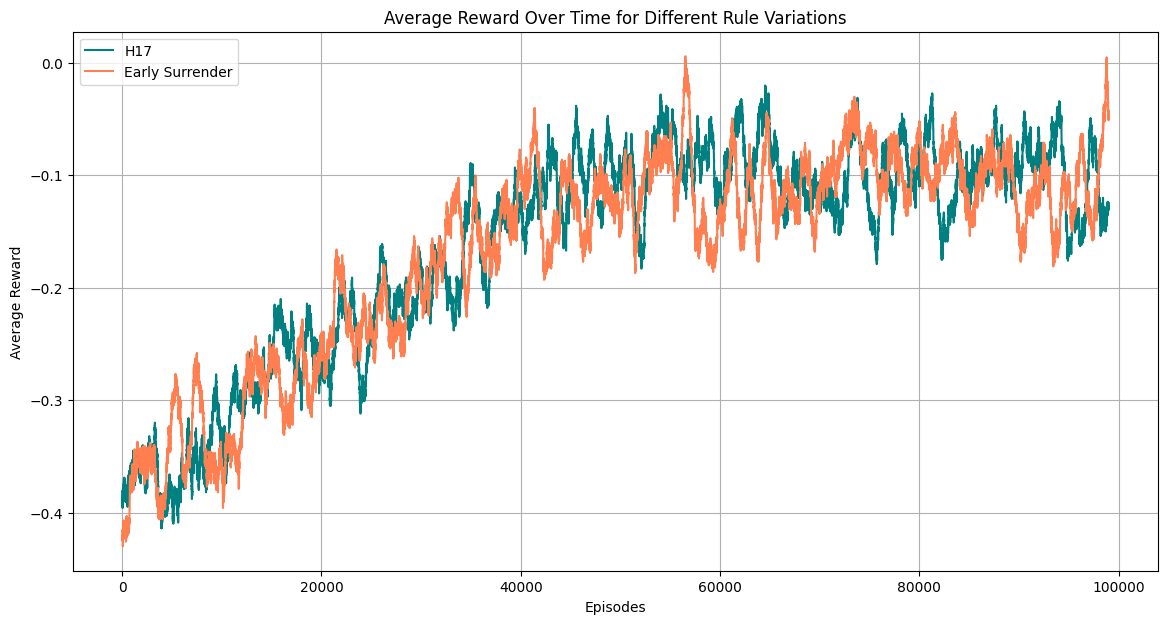

In [ ]:
# Plotting average rewards over episodes
def plot_training_rewards(agent_h17, agent_surrender):
    length_step = 1000

    # H17
    reward_moving_average_h17 = np.convolve(np.array(agent_h17.episode_rewards).flatten(), np.ones(length_step) / length_step, mode="valid")

    # Early Surrender
    reward_moving_average_surrender = np.convolve(np.array(agent_surrender.episode_rewards).flatten(), np.ones(length_step) / length_step, mode="valid")

    plt.figure(figsize=(14, 7))
    plt.plot(range(len(reward_moving_average_h17)), reward_moving_average_h17, label='H17', color='teal')
    plt.plot(range(len(reward_moving_average_surrender)), reward_moving_average_surrender, label='Early Surrender', color='coral')
    plt.xlabel('Episodes')
    plt.ylabel('Average Reward')
    plt.title('Average Reward Over Time for Different Rule Variations')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_rewards(agent_h17, agent_surrender)


## Policy Grids for Rule Variations

We visualize the policies learned by the agents for each rule variation.


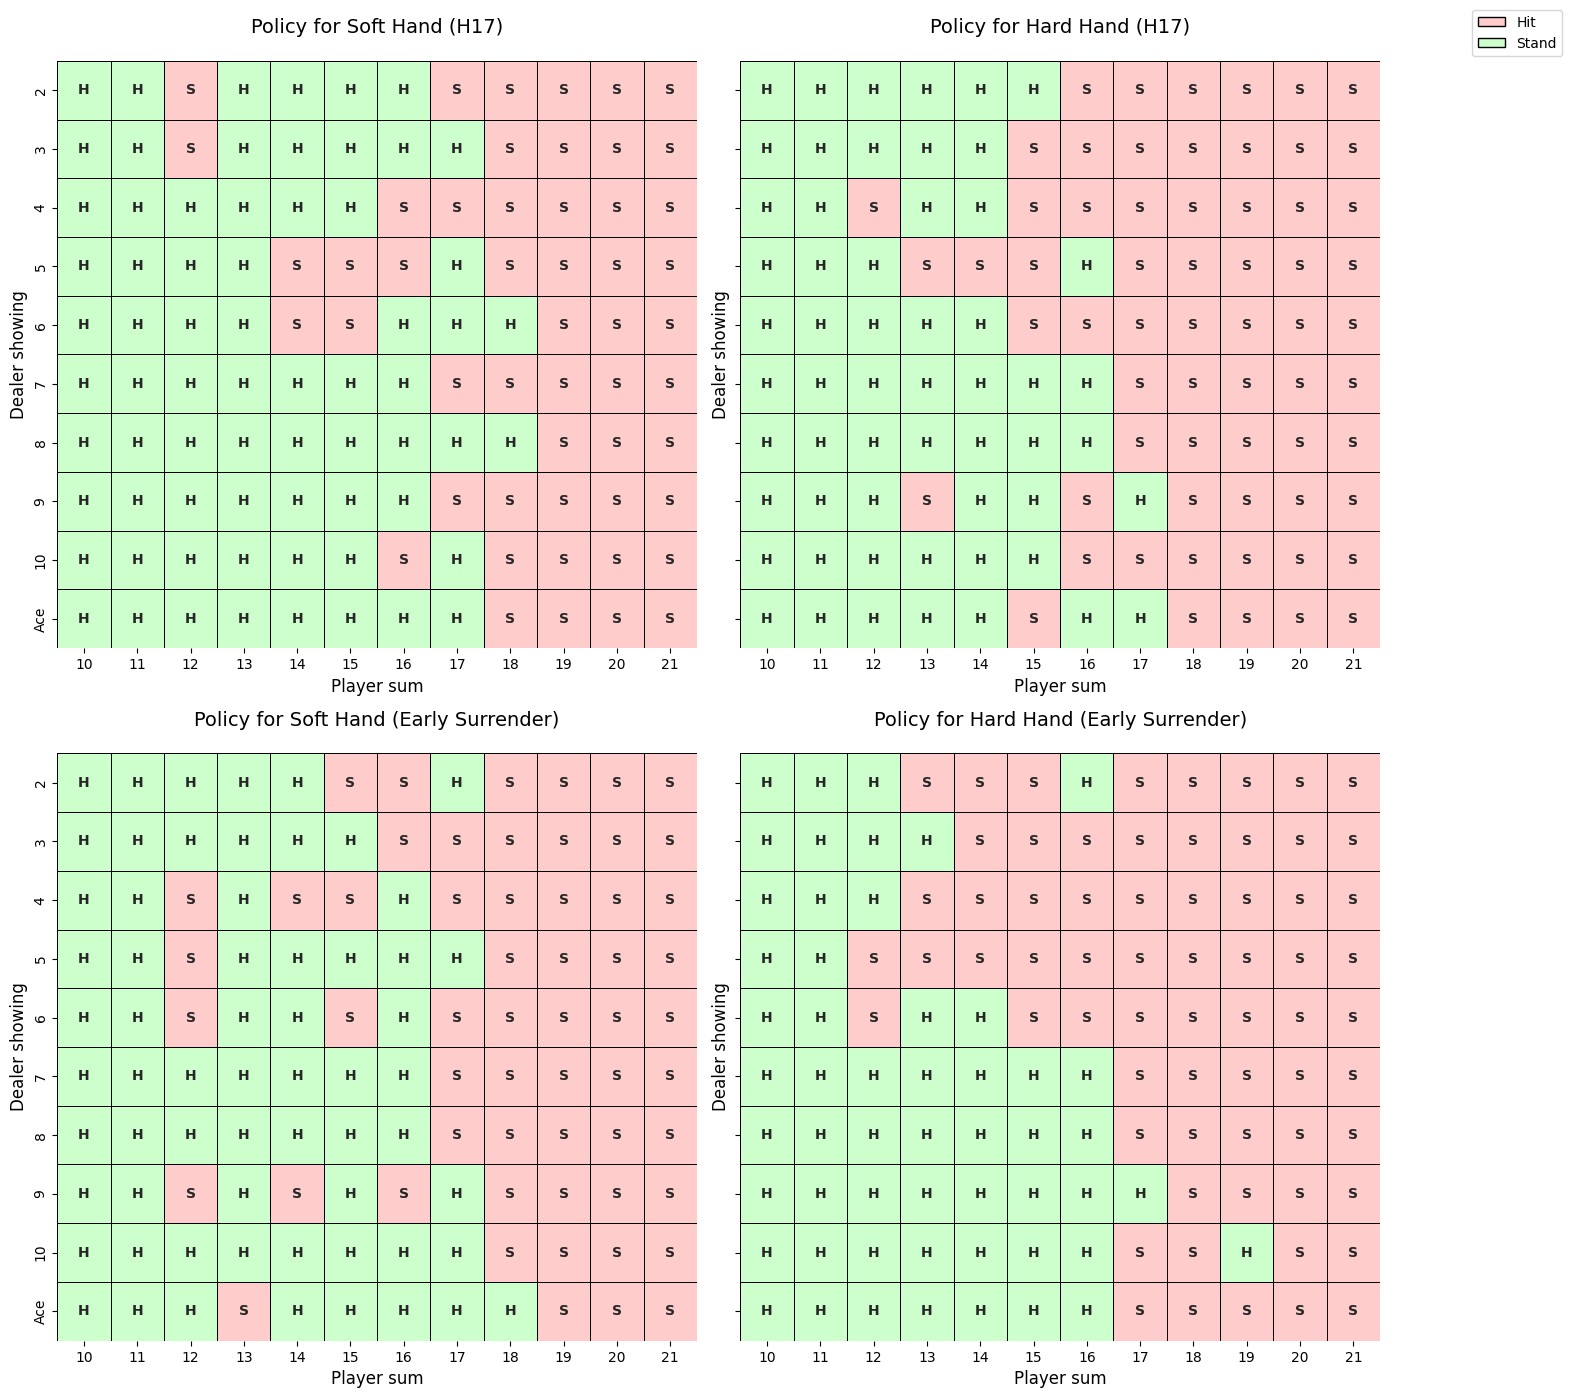

In [ ]:
from matplotlib.patches import Patch

def create_policy_grid(agent, soft=True):
    policy = defaultdict(int)
    for state_action in agent.Q.keys():
        state, action = state_action
        is_soft = state[2]
        if (soft and is_soft) or (not soft and not is_soft):
            state_key = (state[0], state[1], state[2], state[3], state[4])
            policy[state_key] = 'H' if max(['hit', 'stand'], key=lambda a: agent.Q.get((state, a), 0)) == 'hit' else 'S'

    player_count, dealer_count = np.meshgrid(np.arange(10, 22), np.arange(2, 12))
    policy_grid = np.apply_along_axis(lambda state: policy.get((state[0], state[1], soft, False, False), 'H'), axis=2, arr=np.dstack([player_count, dealer_count]))

    return policy_grid

def plot_policy_grids(agent_h17, agent_surrender):
    policy_grid_soft_h17 = create_policy_grid(agent_h17, soft=True)
    policy_grid_hard_h17 = create_policy_grid(agent_h17, soft=False)
    policy_grid_soft_surrender = create_policy_grid(agent_surrender, soft=True)
    policy_grid_hard_surrender = create_policy_grid(agent_surrender, soft=False)

    player_count, dealer_count = np.meshgrid(np.arange(10, 22), np.arange(2, 12))

    fig, axs = plt.subplots(2, 2, figsize=(14, 14), sharey=True)

    sns.heatmap(policy_grid_soft_h17 == 'H', linewidth=0.5, annot=policy_grid_soft_h17, fmt='', cmap=['#ffcccc', '#ccffcc'], cbar=False, ax=axs[0, 0], linecolor='black', annot_kws={"size": 10, "weight": "bold"})
    axs[0, 0].set_title("Policy for Soft Hand (H17)", fontsize=14, pad=20)
    axs[0, 0].set_xlabel("Player sum", fontsize=12)
    axs[0, 0].set_ylabel("Dealer showing", fontsize=12)
    axs[0, 0].set_xticklabels(np.arange(10, 22), fontsize=10)
    axs[0, 0].set_yticklabels([2, 3, 4, 5, 6, 7, 8, 9, 10, "Ace"], fontsize=10)

    sns.heatmap(policy_grid_hard_h17 == 'H', linewidth=0.5, annot=policy_grid_hard_h17, fmt='', cmap=['#ffcccc', '#ccffcc'], cbar=False, ax=axs[0, 1], linecolor='black', annot_kws={"size": 10, "weight": "bold"})
    axs[0, 1].set_title("Policy for Hard Hand (H17)", fontsize=14, pad=20)
    axs[0, 1].set_xlabel("Player sum", fontsize=12)
    axs[0, 1].set_ylabel("Dealer showing", fontsize=12)
    axs[0, 1].set_xticklabels(np.arange(10, 22), fontsize=10)
    axs[0, 1].set_yticklabels([2, 3, 4, 5, 6, 7, 8, 9, 10, "Ace"], fontsize=10)

    sns.heatmap(policy_grid_soft_surrender == 'H', linewidth=0.5, annot=policy_grid_soft_surrender, fmt='', cmap=['#ffcccc', '#ccffcc'], cbar=False, ax=axs[1, 0], linecolor='black', annot_kws={"size": 10, "weight": "bold"})
    axs[1, 0].set_title("Policy for Soft Hand (Early Surrender)", fontsize=14, pad=20)
    axs[1, 0].set_xlabel("Player sum", fontsize=12)
    axs[1, 0].set_ylabel("Dealer showing", fontsize=12)
    axs[1, 0].set_xticklabels(np.arange(10, 22), fontsize=10)
    axs[1, 0].set_yticklabels([2, 3, 4, 5, 6, 7, 8, 9, 10, "Ace"], fontsize=10)

    sns.heatmap(policy_grid_hard_surrender == 'H', linewidth=0.5, annot=policy_grid_hard_surrender, fmt='', cmap=['#ffcccc', '#ccffcc'], cbar=False, ax=axs[1, 1], linecolor='black', annot_kws={"size": 10, "weight": "bold"})
    axs[1, 1].set_title("Policy for Hard Hand (Early Surrender)", fontsize=14, pad=20)
    axs[1, 1].set_xlabel("Player sum", fontsize=12)
    axs[1, 1].set_ylabel("Dealer showing", fontsize=12)
    axs[1, 1].set_xticklabels(np.arange(10, 22), fontsize=10)
    axs[1, 1].set_yticklabels([2, 3, 4, 5, 6, 7, 8, 9, 10, "Ace"], fontsize=10)

    legend_elements = [Patch(facecolor="#ffcccc", edgecolor="black", label="Hit"), Patch(facecolor="#ccffcc", edgecolor="black", label="Stand")]
    fig.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

plot_policy_grids(agent_h17, agent_surrender)


## Q-Value Optimization for Rule Variations

We visualize the Q-value optimization for different actions and rule variations using 3D plots.


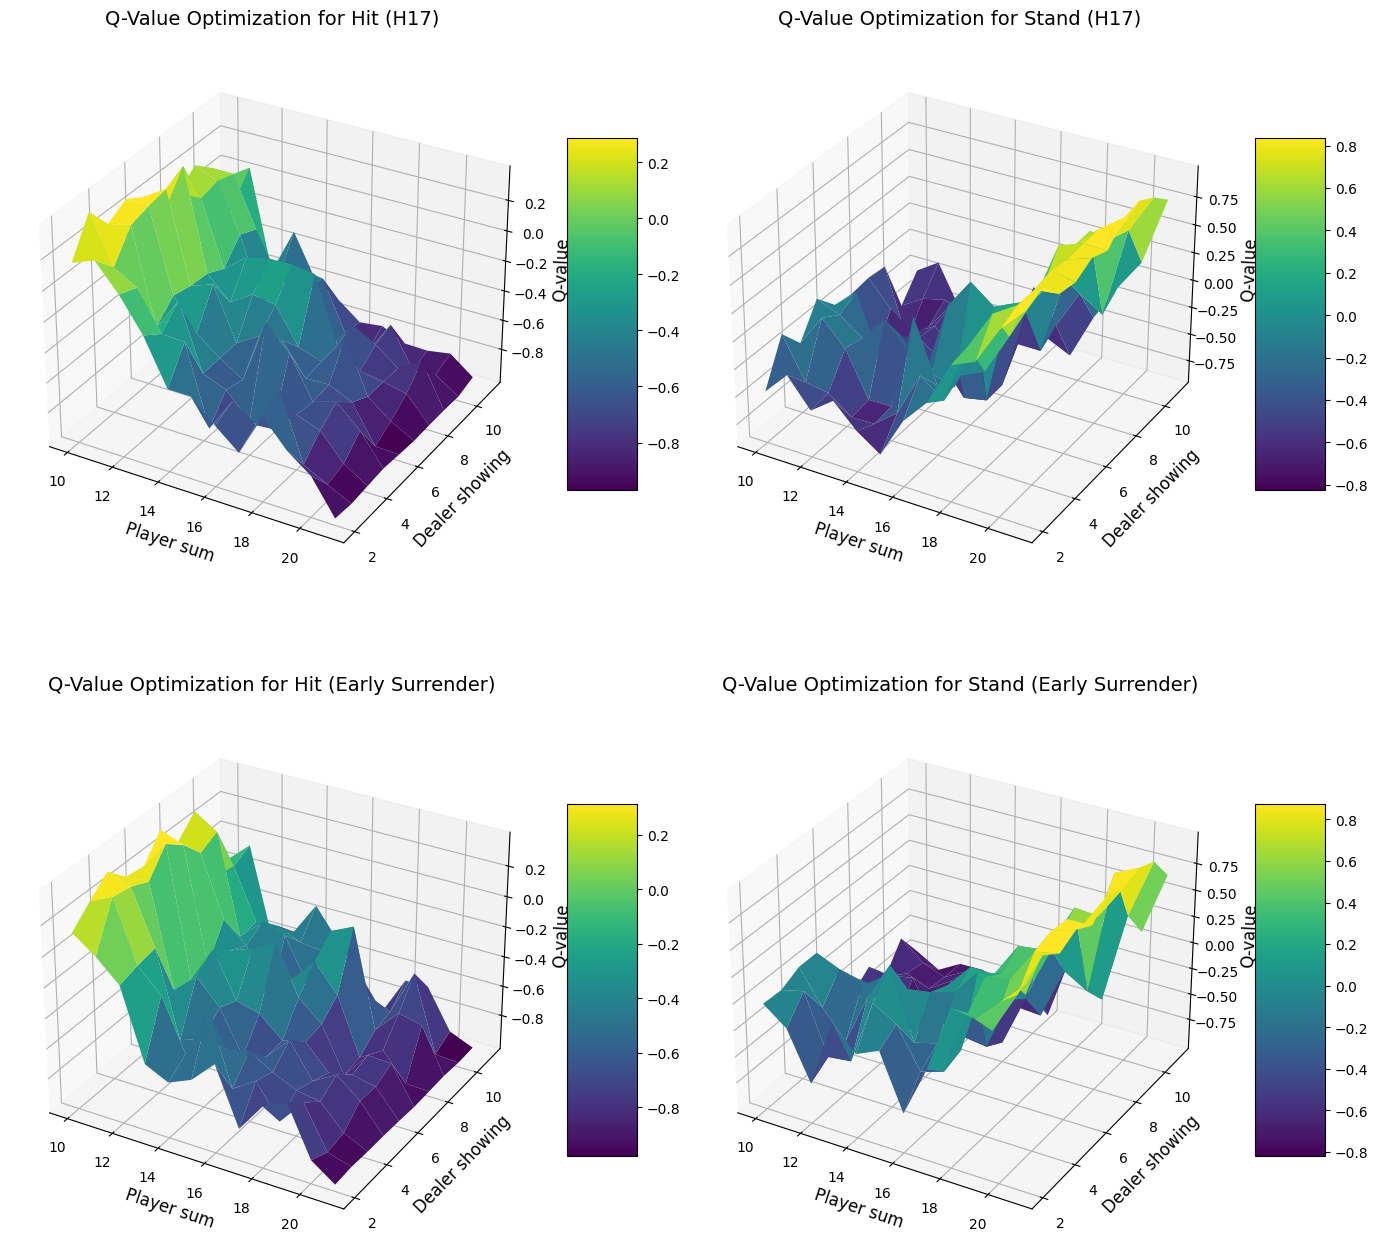

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

def create_q_value_grid(agent, action='hit'):
    q_values = defaultdict(float)
    for state_action in agent.Q.keys():
        state, action_taken = state_action
        if action_taken == action:
            q_values[state] = agent.Q[state_action]

    player_count, dealer_count = np.meshgrid(np.arange(10, 22), np.arange(2, 12))
    q_value_grid = np.apply_along_axis(lambda state: q_values.get((state[0], state[1], False, False, False), 0), axis=2, arr=np.dstack([player_count, dealer_count]))

    return player_count, dealer_count, q_value_grid

def plot_q_value_grids(agent_h17, agent_surrender):
    player_count, dealer_count = np.meshgrid(np.arange(10, 22), np.arange(2, 12))

    q_value_grid_hit_h17 = create_q_value_grid(agent_h17, action='hit')[2]
    q_value_grid_stand_h17 = create_q_value_grid(agent_h17, action='stand')[2]
    q_value_grid_hit_surrender = create_q_value_grid(agent_surrender, action='hit')[2]
    q_value_grid_stand_surrender = create_q_value_grid(agent_surrender, action='stand')[2]

    fig = plt.figure(figsize=(14, 14))

    ax1 = fig.add_subplot(221, projection='3d')
    surf1 = ax1.plot_surface(player_count, dealer_count, q_value_grid_hit_h17, cmap='viridis', edgecolor='none')
    ax1.set_title("Q-Value Optimization for Hit (H17)", fontsize=14, pad=20)
    ax1.set_xlabel("Player sum", fontsize=12)
    ax1.set_ylabel("Dealer showing", fontsize=12)
    ax1.set_zlabel("Q-value", fontsize=12)
    fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)

    ax2 = fig.add_subplot(222, projection='3d')
    surf2 = ax2.plot_surface(player_count, dealer_count, q_value_grid_stand_h17, cmap='viridis', edgecolor='none')
    ax2.set_title("Q-Value Optimization for Stand (H17)", fontsize=14, pad=20)
    ax2.set_xlabel("Player sum", fontsize=12)
    ax2.set_ylabel("Dealer showing", fontsize=12)
    ax2.set_zlabel("Q-value", fontsize=12)
    fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)

    ax3 = fig.add_subplot(223, projection='3d')
    surf3 = ax3.plot_surface(player_count, dealer_count, q_value_grid_hit_surrender, cmap='viridis', edgecolor='none')
    ax3.set_title("Q-Value Optimization for Hit (Early Surrender)", fontsize=14, pad=20)
    ax3.set_xlabel("Player sum", fontsize=12)
    ax3.set_ylabel("Dealer showing", fontsize=12)
    ax3.set_zlabel("Q-value", fontsize=12)
    fig.colorbar(surf3, ax=ax3, shrink=0.5, aspect=5)

    ax4 = fig.add_subplot(224, projection='3d')
    surf4 = ax4.plot_surface(player_count, dealer_count, q_value_grid_stand_surrender, cmap='viridis', edgecolor='none')
    ax4.set_title("Q-Value Optimization for Stand (Early Surrender)", fontsize=14, pad=20)
    ax4.set_xlabel("Player sum", fontsize=12)
    ax4.set_ylabel("Dealer showing", fontsize=12)
    ax4.set_zlabel("Q-value", fontsize=12)
    fig.colorbar(surf4, ax=ax4, shrink=0.5, aspect=5)

    plt.tight_layout()
    plt.show()

plot_q_value_grids(agent_h17, agent_surrender)


# Complete Point-Count System with Rule Variation

Here we implement Blackjack with Complete Point-Count System under different rule variations. We compare the win rates for the following rule variations:
1. Dealer Hits Soft 17 (H17)
2. Early Surrender

In [3]:
import numpy as np
import random

class BlackjackEnv:
    def __init__(self, dealer_hits_soft_17=True, early_surrender=False):
        self.deck = self.init_deck()
        self.player_hand = []
        self.dealer_hand = []
        self.split_hand = []
        self.doubled = False
        self.rewards = []
        self.hand_lengths = []
        self.running_count = 0
        self.dealer_hits_soft_17 = dealer_hits_soft_17
        self.early_surrender = early_surrender
        self.reset_game()

    def init_deck(self):
        suits = ['hearts', 'diamonds', 'clubs', 'spades']
        ranks = list(range(2, 11)) + ['jack', 'queen', 'king', 'ace']
        deck = [str(rank) + '_' + suit for rank in ranks for suit in suits]
        random.shuffle(deck)
        return deck

    def draw_card(self):
        card = self.deck.pop(random.randint(0, len(self.deck) - 1))
        self.update_running_count(card)
        return card

    def reset_game(self):
        self.deck = self.init_deck()
        self.player_hand = [self.draw_card(), self.draw_card()]
        self.dealer_hand = [self.draw_card(), self.draw_card()]
        self.running_count = 0

    def update_running_count(self, card):
        rank = card.split('_')[0]
        if rank in ['2', '3', '4', '5', '6']:
            self.running_count += 1
        elif rank in ['10', 'jack', 'queen', 'king', 'ace']:
            self.running_count -= 1

    def get_card_value(self, card):
        rank = card.split('_')[0]
        if rank in ['jack', 'queen', 'king']:
            return 10
        elif rank == 'ace':
            return 11
        else:
            return int(rank)

    def hand_value(self, hand):
        value = sum(self.get_card_value(card) for card in hand)
        if value > 21 and any(card.startswith('ace') for card in hand):
            value -= 10
        return value

    def is_soft_hand(self, hand):
        return any(card.startswith('ace') for card in hand) and self.hand_value(hand) <= 21

    def is_busted(self, hand):
        return self.hand_value(hand) > 21

    def dealer_play(self):
        while self.hand_value(self.dealer_hand) < 17 or (self.dealer_hits_soft_17 and self.hand_value(self.dealer_hand) == 17 and self.is_soft_hand(self.dealer_hand)):
            self.dealer_hand.append(self.draw_card())

    def is_pair(self, hand):
        return len(hand) == 2 and hand[0].split('_')[0] == hand[1].split('_')[0]

    def step(self, action):
        if action == 'hit':
            self.player_hand.append(self.draw_card())
            if self.is_busted(self.player_hand):
                self.rewards.append(-1)
                self.hand_lengths.append(len(self.player_hand))
                return 'terminal', -2 if self.doubled else -1, True
        elif action == 'stand':
            self.dealer_play()
            player_value = self.hand_value(self.player_hand)
            dealer_value = self.hand_value(self.dealer_hand)
            if self.is_busted(self.dealer_hand) or player_value > dealer_value:
                self.rewards.append(1)
                self.hand_lengths.append(len(self.player_hand))
                return 'terminal', 1, True
            elif dealer_value > player_value:
                self.rewards.append(-1)
                self.hand_lengths.append(len(self.player_hand))
                return 'terminal', -1, True
            else:
                self.rewards.append(0)
                self.hand_lengths.append(len(self.player_hand))
                return 'terminal', 0, True

        elif action == 'split' and self.is_pair(self.player_hand):
            self.split_hand = [self.player_hand.pop()]
            self.player_hand.append(self.draw_card())
            self.split_hand.append(self.draw_card())
            return self.get_state(), 0, False

        elif action == 'double':
            self.doubled = True
            self.player_hand.append(self.draw_card())
            if self.is_busted(self.player_hand):
                return 'terminal', -2, True
            return self.get_state(), 0, False

        return self.get_state(), 0, False

    def get_state(self):
        return (
            self.hand_value(self.player_hand),
            self.get_card_value(self.dealer_hand[0]),
            self.is_soft_hand(self.player_hand),
            len(self.split_hand) > 0,
            self.doubled,
            self.running_count
        )


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

class QLearningAgent:
    def __init__(self, env, episodes, start_epsilon, decay_epsilon, min_epsilon, learning_rate=0.1, discount=0.99):
        self.env = env
        self.alpha = learning_rate
        self.gamma = discount
        self.epsilon = start_epsilon
        self.total_episodes = episodes
        self.epsilon_decay = decay_epsilon
        self.min_epsilon = min_epsilon
        self.Q = defaultdict(float)
        self.errors = []
        self.episode_rewards = []

    def get_q_value(self, state, action):
        return self.Q.get((state, action), 0)

    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(['hit', 'stand'])
        else:
            return max(['hit', 'stand'], key=lambda action: self.get_q_value(state, action))

    def update_q_value(self, state, action, next_state, reward):
        current_q = self.get_q_value(state, action)
        next_q = max(self.get_q_value(next_state, a) for a in ['hit', 'stand'])
        td_error = reward + self.gamma * next_q - current_q
        self.Q[(state, action)] = current_q + self.alpha * td_error
        self.errors.append(td_error)

    def decay_epsilon(self):
        self.epsilon = max(self.min_epsilon, self.epsilon - self.epsilon_decay)

    def train(self):
        for episode in range(self.total_episodes):
            self.env.reset_game()
            state = self.env.get_state()
            done = False
            total_reward = 0
            while not done:
                action = self.choose_action(state)
                next_state, reward, done = self.env.step(action)
                self.update_q_value(state, action, next_state, reward)
                state = next_state
                total_reward += reward
            self.episode_rewards.append(total_reward)
            self.decay_epsilon()

    def evaluate(self, num_games=1000):
        win, loss, tie = 0, 0, 0
        for _ in range(num_games):
            self.env.reset_game()
            state = self.env.get_state()
            done = False
            while not done:
                action = max(['hit', 'stand'], key=lambda action: self.get_q_value(state, action))
                state, reward, done = self.env.step(action)
            if reward > 0:
                win += 1
            elif reward < 0:
                loss += 1
            else:
                tie += 1
        return win, loss, tie

def train_agent_with_variations(env_params, episodes=100000):
    environment = BlackjackEnv(**env_params)
    agent = QLearningAgent(environment, episodes, start_epsilon=1.0, decay_epsilon=1.0 / (episodes / 2), min_epsilon=0.1)
    agent.train()
    return agent


In [ ]:
# Training with Dealer Hits Soft 17 (H17)
env_params_h17 = {'dealer_hits_soft_17': True, 'early_surrender': False}
agent_h17 = train_agent_with_variations(env_params_h17)

# Training with Early Surrender
env_params_surrender = {'dealer_hits_soft_17': False, 'early_surrender': True}
agent_surrender = train_agent_with_variations(env_params_surrender)

In [ ]:
# Evaluate the agents' performance
wins_h17, losses_h17, ties_h17 = agent_h17.evaluate(num_games=10000)
wins_surrender, losses_surrender, ties_surrender = agent_surrender.evaluate(num_games=10000)

# Calculate win, loss, and tie rates
total_games_h17 = wins_h17 + losses_h17 + ties_h17
win_rate_h17 = (wins_h17 / total_games_h17) * 100
loss_rate_h17 = (losses_h17 / total_games_h17) * 100
tie_rate_h17 = (ties_h17 / total_games_h17) * 100

total_games_surrender = wins_surrender + losses_surrender + ties_surrender
win_rate_surrender = (wins_surrender / total_games_surrender) * 100
loss_rate_surrender = (losses_surrender / total_games_surrender) * 100
tie_rate_surrender = (ties_surrender / total_games_surrender) * 100

print(f"H17 Evaluation: {wins_h17} wins, {losses_h17} losses, {ties_h17} ties")
print(f"H17 Win rate: {win_rate_h17:.2f}%, Loss rate: {loss_rate_h17:.2f}%, Tie rate: {tie_rate_h17:.2f}%")

print("-" * 50)

print(f"Surrender Evaluation: {wins_surrender} wins, {losses_surrender} losses, {ties_surrender} ties")
print(f"Surrender Win rate: {win_rate_surrender:.2f}%, Loss rate: {loss_rate_surrender:.2f}%, Tie rate: {tie_rate_surrender:.2f}%")

H17 Evaluation: 4192 wins, 4960 losses, 848 ties
H17 Win rate: 41.92%, Loss rate: 49.60%, Tie rate: 8.48%
--------------------------------------------------
Surrender Evaluation: 4314 wins, 4819 losses, 867 ties
Surrender Win rate: 43.14%, Loss rate: 48.19%, Tie rate: 8.67%


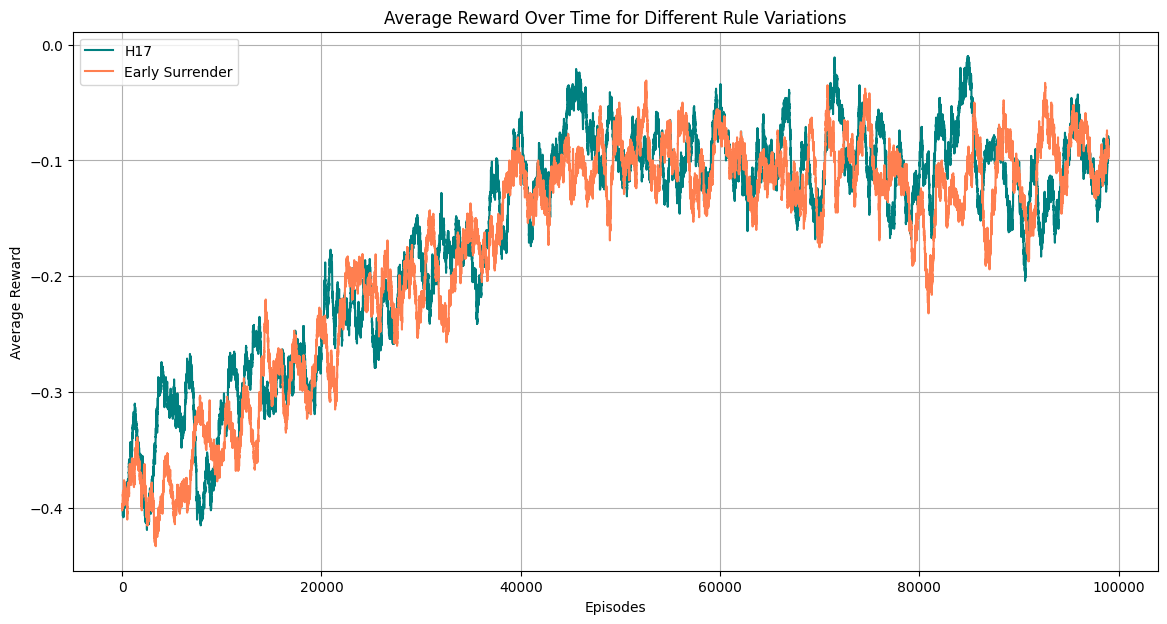

In [ ]:
# Plotting average rewards over episodes
def plot_training_rewards(agent_h17, agent_surrender):
    length_step = 1000

    # H17
    reward_moving_average_h17 = np.convolve(np.array(agent_h17.episode_rewards).flatten(), np.ones(length_step) / length_step, mode="valid")

    # Early Surrender
    reward_moving_average_surrender = np.convolve(np.array(agent_surrender.episode_rewards).flatten(), np.ones(length_step) / length_step, mode="valid")

    plt.figure(figsize=(14, 7))
    plt.plot(range(len(reward_moving_average_h17)), reward_moving_average_h17, label='H17', color='teal')
    plt.plot(range(len(reward_moving_average_surrender)), reward_moving_average_surrender, label='Early Surrender', color='coral')
    plt.xlabel('Episodes')
    plt.ylabel('Average Reward')
    plt.title('Average Reward Over Time for Different Rule Variations')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_rewards(agent_h17, agent_surrender)


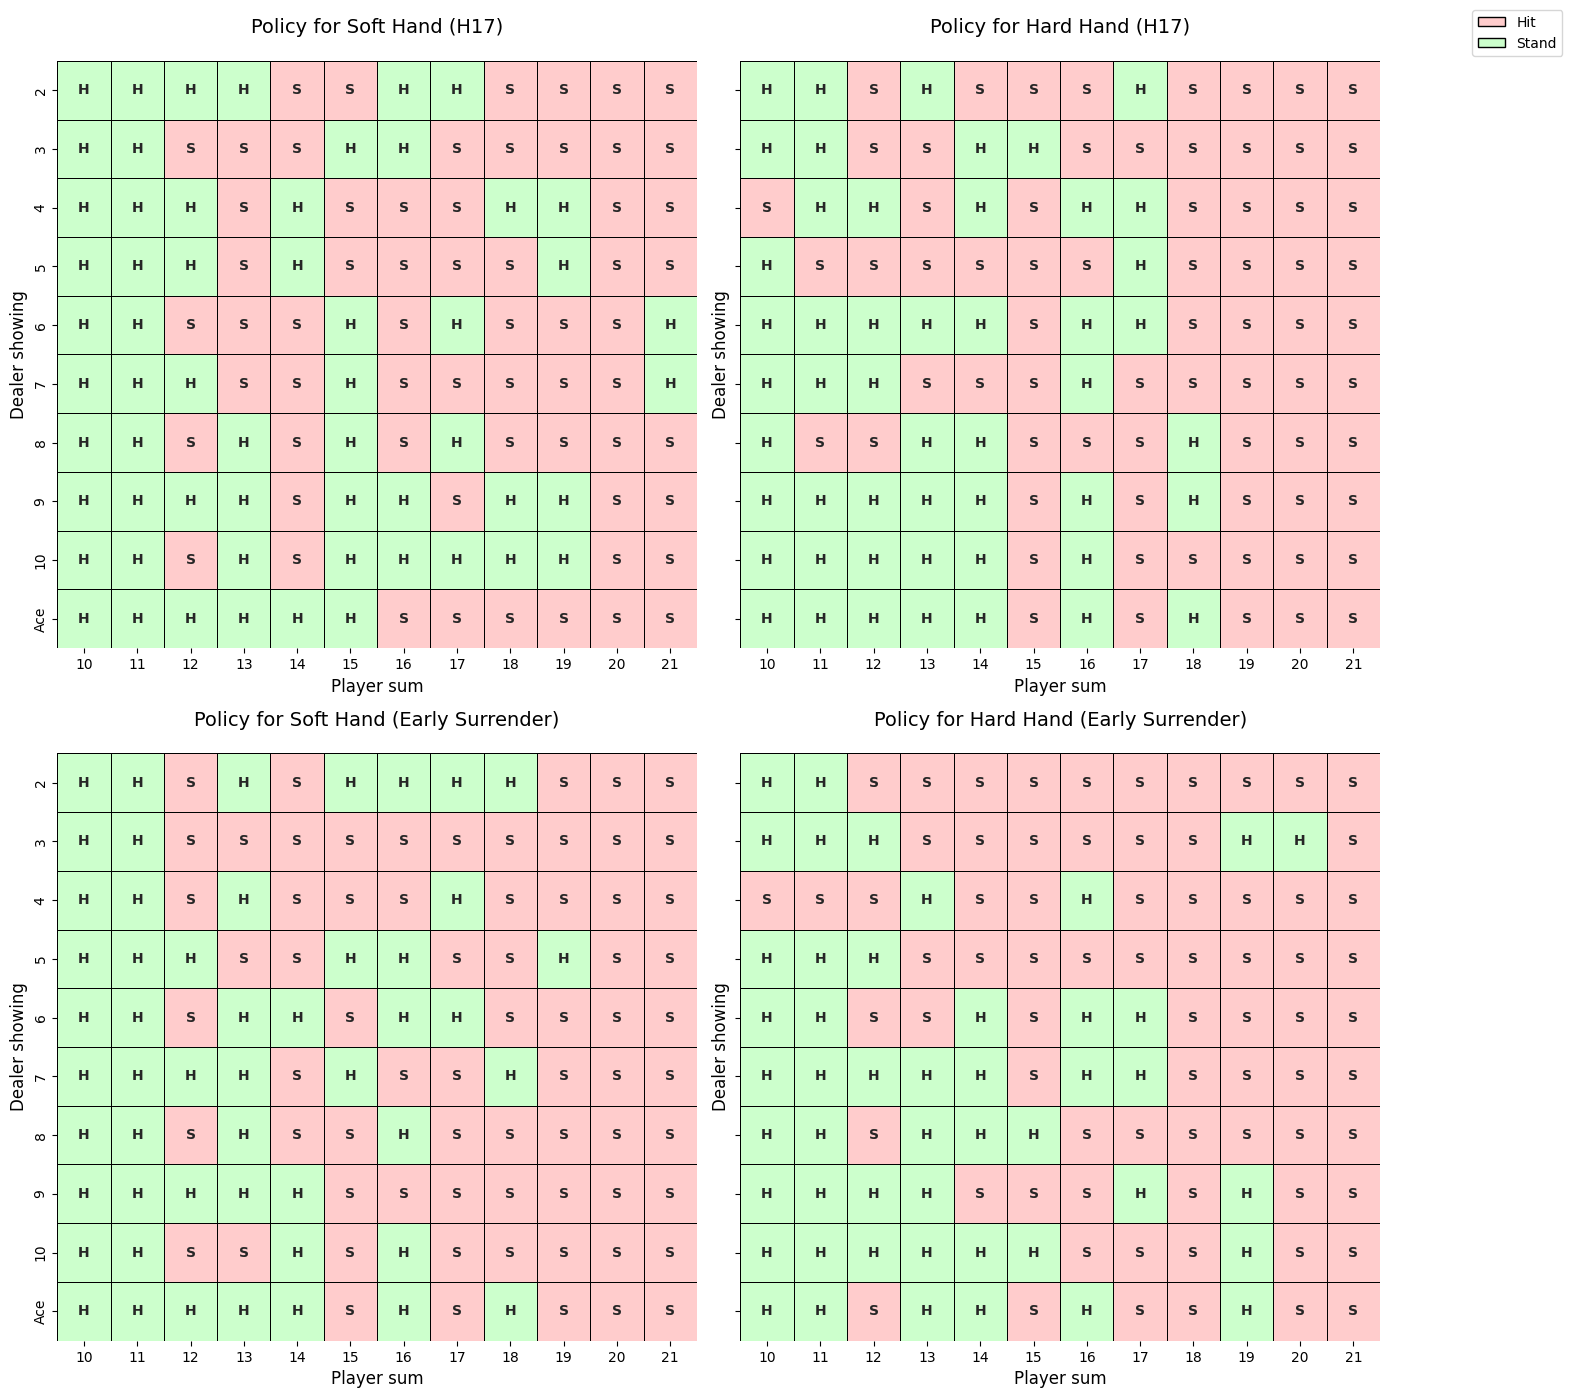

In [ ]:
from matplotlib.patches import Patch

def create_policy_grid(agent, soft=True):
    policy = defaultdict(int)
    for state_action in agent.Q.keys():
        state, action = state_action
        is_soft = state[2]
        if (soft and is_soft) or (not soft and not is_soft):
            state_key = (state[0], state[1], state[2], state[3], state[4])
            policy[state_key] = 'H' if max(['hit', 'stand'], key=lambda a: agent.Q.get((state, a), 0)) == 'hit' else 'S'

    player_count, dealer_count = np.meshgrid(np.arange(10, 22), np.arange(2, 12))
    policy_grid = np.apply_along_axis(lambda state: policy.get((state[0], state[1], soft, False, False), 'H'), axis=2, arr=np.dstack([player_count, dealer_count]))

    return policy_grid

def plot_policy_grids(agent_h17, agent_surrender):
    policy_grid_soft_h17 = create_policy_grid(agent_h17, soft=True)
    policy_grid_hard_h17 = create_policy_grid(agent_h17, soft=False)
    policy_grid_soft_surrender = create_policy_grid(agent_surrender, soft=True)
    policy_grid_hard_surrender = create_policy_grid(agent_surrender, soft=False)

    player_count, dealer_count = np.meshgrid(np.arange(10, 22), np.arange(2, 12))

    fig, axs = plt.subplots(2, 2, figsize=(14, 14), sharey=True)

    sns.heatmap(policy_grid_soft_h17 == 'H', linewidth=0.5, annot=policy_grid_soft_h17, fmt='', cmap=['#ffcccc', '#ccffcc'], cbar=False, ax=axs[0, 0], linecolor='black', annot_kws={"size": 10, "weight": "bold"})
    axs[0, 0].set_title("Policy for Soft Hand (H17)", fontsize=14, pad=20)
    axs[0, 0].set_xlabel("Player sum", fontsize=12)
    axs[0, 0].set_ylabel("Dealer showing", fontsize=12)
    axs[0, 0].set_xticklabels(np.arange(10, 22), fontsize=10)
    axs[0, 0].set_yticklabels([2, 3, 4, 5, 6, 7, 8, 9, 10, "Ace"], fontsize=10)

    sns.heatmap(policy_grid_hard_h17 == 'H', linewidth=0.5, annot=policy_grid_hard_h17, fmt='', cmap=['#ffcccc', '#ccffcc'], cbar=False, ax=axs[0, 1], linecolor='black', annot_kws={"size": 10, "weight": "bold"})
    axs[0, 1].set_title("Policy for Hard Hand (H17)", fontsize=14, pad=20)
    axs[0, 1].set_xlabel("Player sum", fontsize=12)
    axs[0, 1].set_ylabel("Dealer showing", fontsize=12)
    axs[0, 1].set_xticklabels(np.arange(10, 22), fontsize=10)
    axs[0, 1].set_yticklabels([2, 3, 4, 5, 6, 7, 8, 9, 10, "Ace"], fontsize=10)

    sns.heatmap(policy_grid_soft_surrender == 'H', linewidth=0.5, annot=policy_grid_soft_surrender, fmt='', cmap=['#ffcccc', '#ccffcc'], cbar=False, ax=axs[1, 0], linecolor='black', annot_kws={"size": 10, "weight": "bold"})
    axs[1, 0].set_title("Policy for Soft Hand (Early Surrender)", fontsize=14, pad=20)
    axs[1, 0].set_xlabel("Player sum", fontsize=12)
    axs[1, 0].set_ylabel("Dealer showing", fontsize=12)
    axs[1, 0].set_xticklabels(np.arange(10, 22), fontsize=10)
    axs[1, 0].set_yticklabels([2, 3, 4, 5, 6, 7, 8, 9, 10, "Ace"], fontsize=10)

    sns.heatmap(policy_grid_hard_surrender == 'H', linewidth=0.5, annot=policy_grid_hard_surrender, fmt='', cmap=['#ffcccc', '#ccffcc'], cbar=False, ax=axs[1, 1], linecolor='black', annot_kws={"size": 10, "weight": "bold"})
    axs[1, 1].set_title("Policy for Hard Hand (Early Surrender)", fontsize=14, pad=20)
    axs[1, 1].set_xlabel("Player sum", fontsize=12)
    axs[1, 1].set_ylabel("Dealer showing", fontsize=12)
    axs[1, 1].set_xticklabels(np.arange(10, 22), fontsize=10)
    axs[1, 1].set_yticklabels([2, 3, 4, 5, 6, 7, 8, 9, 10, "Ace"], fontsize=10)

    legend_elements = [Patch(facecolor="#ffcccc", edgecolor="black", label="Hit"), Patch(facecolor="#ccffcc", edgecolor="black", label="Stand")]
    fig.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

plot_policy_grids(agent_h17, agent_surrender)


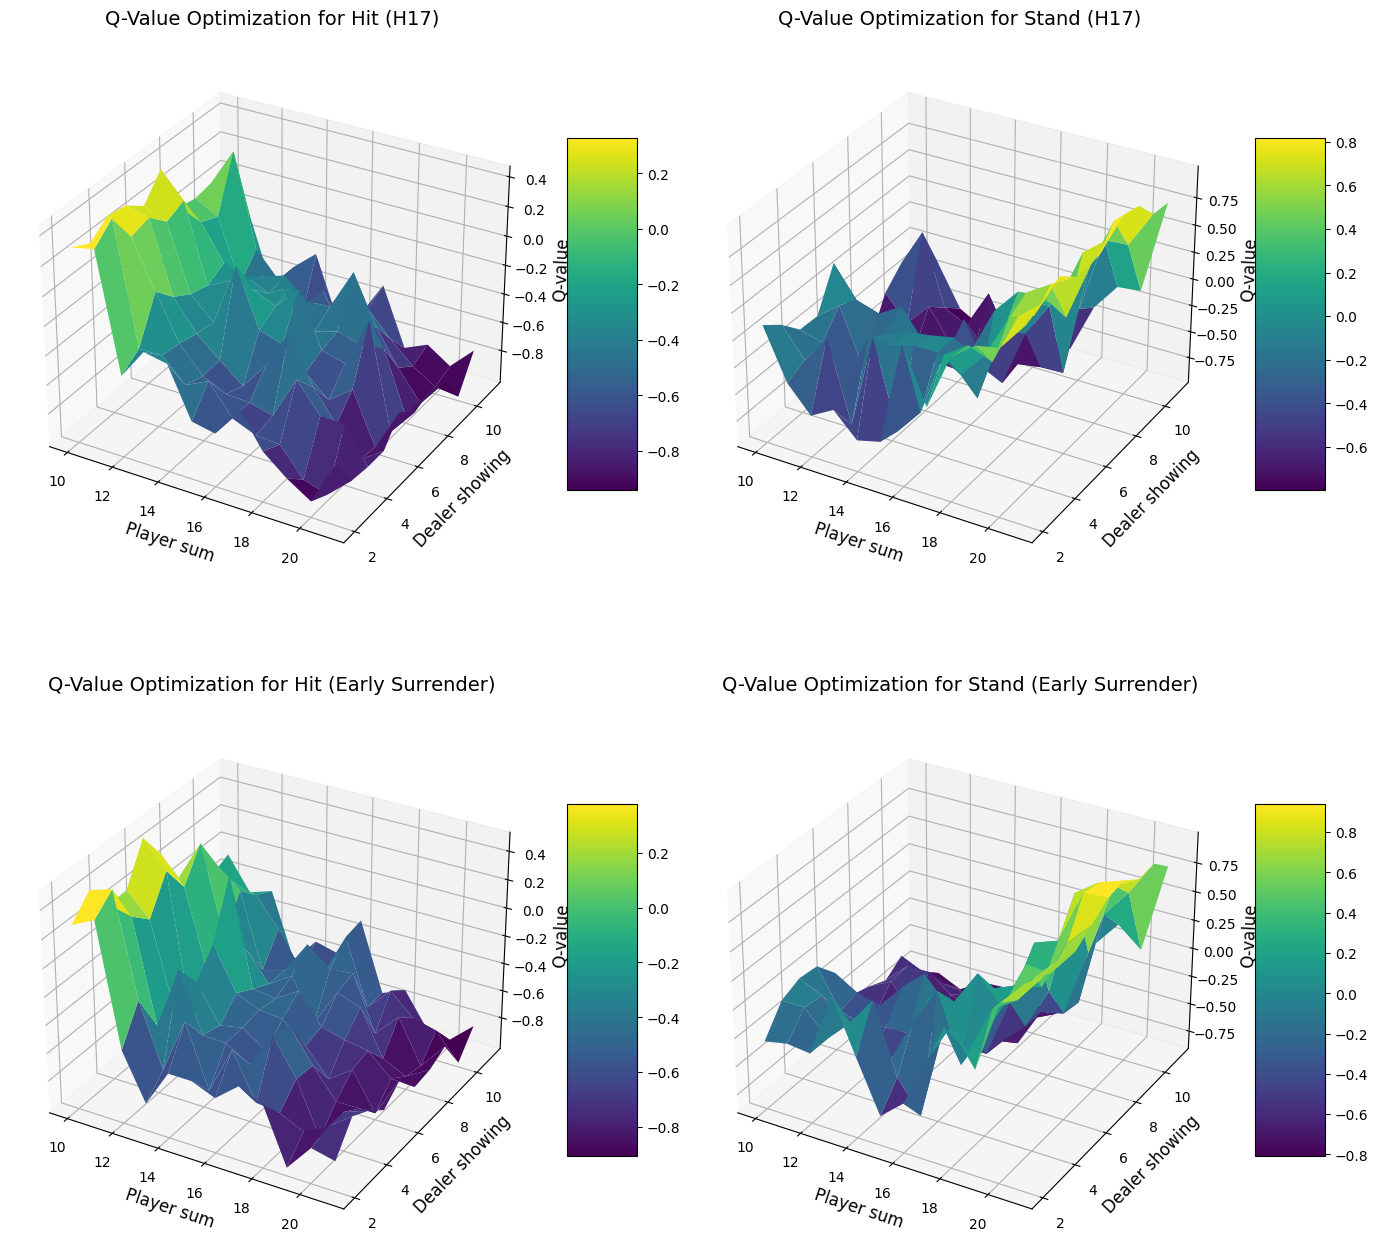

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

def create_q_value_grid(agent, action='hit'):
    q_values = defaultdict(float)
    for state_action in agent.Q.keys():
        state, action_taken = state_action
        if action_taken == action:
            q_values[state] = agent.Q[state_action]

    player_count, dealer_count = np.meshgrid(np.arange(10, 22), np.arange(2, 12))
    q_value_grid = np.zeros_like(player_count, dtype=float)

    for i in range(player_count.shape[0]):
        for j in range(player_count.shape[1]):
            state_key = (player_count[i, j], dealer_count[i, j], False, False, False, 0)
            q_value_grid[i, j] = q_values.get(state_key, 0)

    return player_count, dealer_count, q_value_grid

def plot_q_value_grids(agent_h17, agent_surrender):
    player_count, dealer_count = np.meshgrid(np.arange(10, 22), np.arange(2, 12))

    q_value_grid_hit_h17 = create_q_value_grid(agent_h17, action='hit')[2]
    q_value_grid_stand_h17 = create_q_value_grid(agent_h17, action='stand')[2]
    q_value_grid_hit_surrender = create_q_value_grid(agent_surrender, action='hit')[2]
    q_value_grid_stand_surrender = create_q_value_grid(agent_surrender, action='stand')[2]

    fig = plt.figure(figsize=(14, 14))

    ax1 = fig.add_subplot(221, projection='3d')
    surf1 = ax1.plot_surface(player_count, dealer_count, q_value_grid_hit_h17, cmap='viridis', edgecolor='none')
    ax1.set_title("Q-Value Optimization for Hit (H17)", fontsize=14, pad=20)
    ax1.set_xlabel("Player sum", fontsize=12)
    ax1.set_ylabel("Dealer showing", fontsize=12)
    ax1.set_zlabel("Q-value", fontsize=12)
    fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)

    ax2 = fig.add_subplot(222, projection='3d')
    surf2 = ax2.plot_surface(player_count, dealer_count, q_value_grid_stand_h17, cmap='viridis', edgecolor='none')
    ax2.set_title("Q-Value Optimization for Stand (H17)", fontsize=14, pad=20)
    ax2.set_xlabel("Player sum", fontsize=12)
    ax2.set_ylabel("Dealer showing", fontsize=12)
    ax2.set_zlabel("Q-value", fontsize=12)
    fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)

    ax3 = fig.add_subplot(223, projection='3d')
    surf3 = ax3.plot_surface(player_count, dealer_count, q_value_grid_hit_surrender, cmap='viridis', edgecolor='none')
    ax3.set_title("Q-Value Optimization for Hit (Early Surrender)", fontsize=14, pad=20)
    ax3.set_xlabel("Player sum", fontsize=12)
    ax3.set_ylabel("Dealer showing", fontsize=12)
    ax3.set_zlabel("Q-value", fontsize=12)
    fig.colorbar(surf3, ax=ax3, shrink=0.5, aspect=5)

    ax4 = fig.add_subplot(224, projection='3d')
    surf4 = ax4.plot_surface(player_count, dealer_count, q_value_grid_stand_surrender, cmap='viridis', edgecolor='none')
    ax4.set_title("Q-Value Optimization for Stand (Early Surrender)", fontsize=14, pad=20)
    ax4.set_xlabel("Player sum", fontsize=12)
    ax4.set_ylabel("Dealer showing", fontsize=12)
    ax4.set_zlabel("Q-value", fontsize=12)
    fig.colorbar(surf4, ax=ax4, shrink=0.5, aspect=5)

    plt.tight_layout()
    plt.show()

plot_q_value_grids(agent_h17, agent_surrender)
